In [15]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

In [22]:
# Loading encoded dataset for modeling
df = pd.read_excel("cleaned_financial_inclusion_data_rural.xlsx")

In [23]:
# Displaying the first few rows and check for nulls and data types
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5946 entries, 0 to 5945
Data columns (total 40 columns):
 #   Column                                                                  Non-Null Count  Dtype  
---  ------                                                                  --------------  -----  
 0   SettlementType                                                          5946 non-null   object 
 1   MaritalStatus                                                           5946 non-null   object 
 2   HouseHoldSize                                                           5946 non-null   float64
 3   SelfEmployed                                                            5946 non-null   int64  
 4   CasualOrSeasonalWorker                                                  5946 non-null   int64  
 5   HasBankOrMicrofinanceAccount                                            5946 non-null   object 
 6   SACCOmember                                                             5946 non

(None,
   SettlementType         MaritalStatus  HouseHoldSize  SelfEmployed  \
 0          Rural  Single/Never Married      -0.945543             0   
 1          Rural  Single/Never Married       0.248473             0   
 2          Rural  Single/Never Married      -0.149532             0   
 3          Rural  Single/Never Married       2.238500             0   
 4          Rural  Single/Never Married       0.248473             0   
 
    CasualOrSeasonalWorker HasBankOrMicrofinanceAccount SACCOmember  \
 0                       1                   Never used  Never used   
 1                       1                   Never used  Never used   
 2                       0                   Never used  Never used   
 3                       0                   Never used  Never used   
 4                       0                   Never used  Never used   
 
   HustlerFundLoan   NHIF/SHIF        NSSF  ...  \
 0      Never used  Never used  Never used  ...   
 1      Never used  Never use

Dataset Summary - the dataset has 40 columns and 5,946 rows, with a mix of numeric (float64, int64) and categorical (object) data.

In [24]:
# Redefining df_clean by dropping high-missing-value columns
df_clean = df.drop(columns=['EducationCompleted_"Other (Specify) "', 'EducationCompleted_95'])

In [25]:
# Defining the target'HasBankOrMicrofinanceAccount' to represent the check for financial inclusion
target = 'HasBankOrMicrofinanceAccount'

# Mapping'HasBankOrMicrofinanceAccount' to binary:
# Never used = 0, Currently using or Previously used = 1
df_clean[target] = df_clean[target].map({
    'Never used': 0,
    'Currently using': 1,
    'Previously used': 1
})

# Converting the target to binary numeric
y = df_clean[target].astype(str)
y = LabelEncoder().fit_transform(y)

# Dropping the original target from features
X = df_clean.drop(columns=[target])


In [26]:
# Re-encoding any object columns in X to numeric
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype(str)
    X[col] = LabelEncoder().fit_transform(X[col])

In [27]:
# Applying SelectKBest feature selection with ANOVA F-test to pick the top features

from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

# Step 1: Removing constant features
vt = VarianceThreshold(threshold=0.0)
X_vt = vt.fit_transform(X)
X_filtered_columns = X.columns[vt.get_support()]
X = pd.DataFrame(X_vt, columns=X_filtered_columns)

selector = SelectKBest(score_func=f_classif, k="all")
X_new = selector.fit_transform(X, y)

# Collecting scores and p-values
scores = selector.scores_
pvalues = selector.pvalues_

# Creating a DataFrame of feature scores
feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-score': scores,
    'p-value': pvalues
}).sort_values(by='p-value')

# Selecting top 7 features with lowest p-values
top_k = 7
top_features = feature_scores.head(top_k)['Feature'].tolist()
X_selected = X[top_features]

# Getting the selected feature names
selected_features = X.columns[selector.get_support()]

important_features = pd.DataFrame({
    "Feature": selected_features,
    "Score": selector.scores_[selector.get_support()],
    "p-value": selector.pvalues_[selector.get_support()]
}).sort_values(by="Score", ascending=False)

important_features.head(7)


,Feature,Score,p-value
31,"EducationCompleted_""University completed """,567.818884,6.064424e-120
8,Primary Mobile Ownership,470.416696,1.872363e-100
20,Has_ID,440.533533,2.054817e-94
23,Digital_Readiness,439.384794,3.511990e-94
32,EducationCompleted_Completed technical trainin...,424.475823,3.720777e-91
9,InternetAccess,260.354769,2.342222e-57
24,Income_Bracket,240.517875,3.306643e-53


In [28]:
# Importing the necessary libraries for feature selection
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [29]:
# Building a Multi-Layer Perceptron (MLP model)
# Importing necessary libraries

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


 Model Evaluation Results
----------------------------------------
 Accuracy: 0.8765

Classification Report:
              precision    recall  f1-score   support

Not Included       0.91      0.94      0.92       949
    Included       0.73      0.61      0.67       241

    accuracy                           0.88      1190
   macro avg       0.82      0.78      0.80      1190
weighted avg       0.87      0.88      0.87      1190



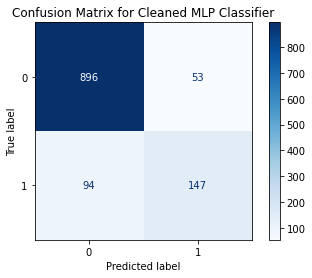

In [30]:
# Filtering the dataset to only selected features
X_mlp = X[selected_features]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mlp, y, test_size=0.2, random_state=42)

# Building and trainning the MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=1000, early_stopping=True, random_state=42)
mlp.fit(X_train, y_train)

# Predicting on test data
y_pred = mlp.predict(X_test)

# Evaluating performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Displaying model results
print(f"\n Model Evaluation Results")
print(("-" * 40))
print(f" Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Included", "Included"]))

# Plotting confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for Cleaned MLP Classifier")
plt.show()

Results Interpretation

The overall model accuracy is at 0.8765, implying a correct prediction of 87.7% of all the cases.

Interpretation by class
1. Class 0 (Not Financially Included)
Precision at 0.91 implies that 91% of predicted “Not Financially Included” were correct.
Recall at 0.94 implying that the model correctly identified 94% of all actual “Not Finacially Included” individuals.
F1-score at 0.92 showing a strong balance of precision and recall.
Conclusion: The model performs very well on the majority class (Not Financially Included)

2. Class 1 (Financially Included)
Precision at 0.73 implies that 73% of predicted “Financially Included” were actually correct.
Recall at 0.61 implying that the model correctly identified only 61% of actual “Financially Included” individuals.
F1-score at 0.67 showing low effectiveness in identifying this class.
Conclusion: The model struggles with minority class detection, likely due to class imbalance (949 vs 241) implying a number of actual financially included individuals are missed (false negatives).Precision is moderate, so when it does predict financial inclusion, it's fairly reliable.


In [31]:
# STEP: Handle class imbalance and retraining the model

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_selected, y)

# Train and split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Resampled training set class distribution:", np.bincount(y_resampled))


Resampled training set class distribution: [4799 4799]


Epoch 1/30
240/240 [==============================] - 1s 2ms/step - loss: 0.5443 - accuracy: 0.7016 - val_loss: 0.4867 - val_accuracy: 0.7474
Epoch 2/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4967 - accuracy: 0.7512 - val_loss: 0.4860 - val_accuracy: 0.7479
Epoch 3/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4930 - accuracy: 0.7492 - val_loss: 0.4855 - val_accuracy: 0.7479
Epoch 4/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4923 - accuracy: 0.7506 - val_loss: 0.4851 - val_accuracy: 0.7521
Epoch 5/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4923 - accuracy: 0.7532 - val_loss: 0.4852 - val_accuracy: 0.7531
Epoch 6/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4872 - accuracy: 0.7510 - val_loss: 0.4857 - val_accuracy: 0.7521
Epoch 7/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4885 - accuracy: 0.7521 - val_loss: 0.4847 - val_accuracy: 0.7531
Epoch 

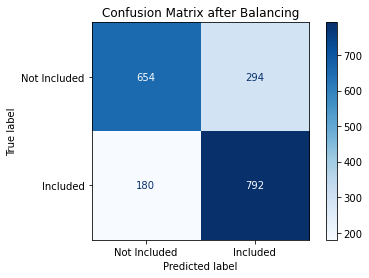

In [32]:
# Training and evaluating the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_test_scaled, y_test))

# Evaluate the model
from sklearn.metrics import classification_report, accuracy_score

y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

print(f"\n Model Evaluation Results")
print(("-" * 40))
print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Included", "Included"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Not Included','Included'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix after Balancing")
plt.show()


In [37]:
# Confirming the features used in retrained model
print("Features used in retrained model:", X_selected.columns.tolist())

Features used in retrained model: ['EducationCompleted_"University completed "', 'Primary Mobile Ownership', 'Has_ID', 'Digital_Readiness', 'EducationCompleted_Completed technical training after secondary school', 'InternetAccess', 'Income_Bracket']



 Model 1: 32 → 16
60/60 [==============================] - 0s 583us/step

 Model 2: 64 → 32
60/60 [==============================] - 0s 513us/step

 Model 3: 128 → 64
60/60 [==============================] - 0s 523us/step

 Model 4: 64 → 64
60/60 [==============================] - 0s 571us/step

 Model 5: 128 → 32
60/60 [==============================] - 0s 671us/step

 Model Evaluation Results
----------------------------------------

 Accuracy: 0.7531

Classification Report:
              precision    recall  f1-score   support

Not Included       0.78      0.69      0.73       948
    Included       0.73      0.81      0.77       972

    accuracy                           0.75      1920
   macro avg       0.76      0.75      0.75      1920
weighted avg       0.76      0.75      0.75      1920



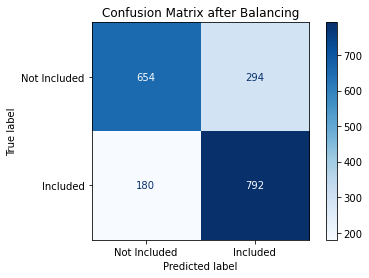

In [38]:
#  Hyperparameter manual tuning for neurons/layers

# Importing the necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
import numpy as np

# Spliting the oversampled data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Defining the architectures to test: (layer1_neurons, layer2_neurons)
architectures = [
    (32, 16),
    (64, 32),
    (128, 64),
    (64, 64),
    (128, 32)
]

# Looping through architectures
for i, (l1, l2) in enumerate(architectures):
    print(f"\n Model {i+1}: {l1} → {l2}")
    
    model = Sequential()
    model.add(Dense(l1, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(l2, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0)

    y_pred_probs = model.predict(X_test_scaled)
    y_pred = (y_pred_probs > 0.5).astype(int)
    
print(f"\n Model Evaluation Results")
print(("-" * 40))
print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Included", "Included"]))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Not Included','Included'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix after Balancing")
plt.show()
    

Epoch 1/30
240/240 [==============================] - 1s 1ms/step - loss: 0.5083 - accuracy: 0.7463 - val_loss: 0.4863 - val_accuracy: 0.7479
Epoch 2/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4909 - accuracy: 0.7525 - val_loss: 0.4902 - val_accuracy: 0.7484
Epoch 3/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4867 - accuracy: 0.7525 - val_loss: 0.4842 - val_accuracy: 0.7484
Epoch 4/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4880 - accuracy: 0.7521 - val_loss: 0.4856 - val_accuracy: 0.7484
Epoch 5/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4860 - accuracy: 0.7561 - val_loss: 0.4818 - val_accuracy: 0.7531
Epoch 6/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4831 - accuracy: 0.7533 - val_loss: 0.4841 - val_accuracy: 0.7495
Epoch 7/30
240/240 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7566 - val_loss: 0.4838 - val_accuracy: 0.7484
Epoch 

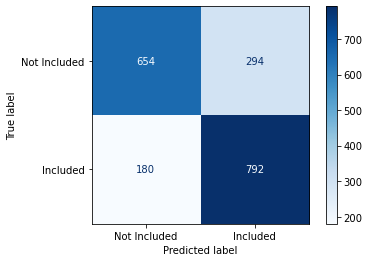

In [45]:
# Defining deeper MLP architecture (MLP Model with three Layers: 128, 64, 32)

# Importing the required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

# Defining the model with 3 hidden layers
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Dropout after first layer

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Dropout after second layer

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))  # Dropout after third layer

model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compilation of the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=1, validation_data=(X_test_scaled, y_test))

# Predict and evaluate
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

print(f"\n Model Evaluation Results")
print(("-" * 40))
print(f"\n Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n lassification Report:")
print(classification_report(y_test, y_pred, target_names=["Not Included", "Included"]))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["Not Included", "Included"])
disp.plot(cmap='Blues')


In [46]:
# confirming columns used in training
print(X_train.columns)


Index(['EducationCompleted_"University completed "',
       'Primary Mobile Ownership', 'Has_ID', 'Digital_Readiness',
       'EducationCompleted_Completed technical training after secondary school',
       'InternetAccess', 'Income_Bracket'],
      dtype='object')


Epoch 1/50
240/240 [==============================] - 1s 1ms/step - loss: 0.5150 - accuracy: 0.7387 - val_loss: 0.4896 - val_accuracy: 0.7484
Epoch 2/50
240/240 [==============================] - 0s 1ms/step - loss: 0.4911 - accuracy: 0.7538 - val_loss: 0.4865 - val_accuracy: 0.7531
Epoch 3/50
240/240 [==============================] - 0s 1ms/step - loss: 0.4882 - accuracy: 0.7550 - val_loss: 0.4828 - val_accuracy: 0.7531
Epoch 4/50
240/240 [==============================] - 0s 1ms/step - loss: 0.4861 - accuracy: 0.7502 - val_loss: 0.4831 - val_accuracy: 0.7495
Epoch 5/50
240/240 [==============================] - 0s 1ms/step - loss: 0.4853 - accuracy: 0.7531 - val_loss: 0.4832 - val_accuracy: 0.7495
Epoch 6/50
240/240 [==============================] - 0s 1ms/step - loss: 0.4848 - accuracy: 0.7562 - val_loss: 0.4838 - val_accuracy: 0.7531
Epoch 7/50
240/240 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.7529 - val_loss: 0.4823 - val_accuracy: 0.7495
Epoch 

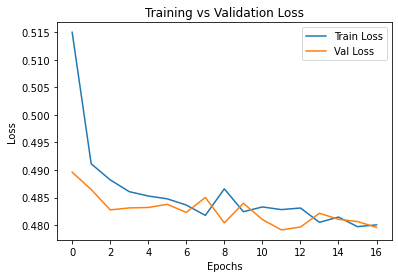

In [47]:
# Monitoring loss curves

from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Rebuild the model to ensure clean state
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model and save history
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


Epoch 1/50
60/60 [==============================] - 0s 599us/steposs: 0.5193 - accuracy: 0.73
Epoch 1: val_f1 = 0.7701, val_acc = 0.7536
240/240 [==============================] - 1s 2ms/step - loss: 0.5124 - accuracy: 0.7399 - val_loss: 0.4920 - val_accuracy: 0.7536
Epoch 2/50
60/60 [==============================] - 0s 590us/steposs: 0.4922 - accuracy: 0.75
Epoch 2: val_f1 = 0.7531, val_acc = 0.7490
240/240 [==============================] - 0s 1ms/step - loss: 0.4912 - accuracy: 0.7520 - val_loss: 0.4860 - val_accuracy: 0.7490
Epoch 3/50
60/60 [==============================] - 0s 529us/steposs: 0.4874 - accuracy: 0.75
Epoch 3: val_f1 = 0.7689, val_acc = 0.7526
240/240 [==============================] - 0s 1ms/step - loss: 0.4887 - accuracy: 0.7544 - val_loss: 0.4856 - val_accuracy: 0.7526
Epoch 4/50
60/60 [==============================] - 0s 448us/steposs: 0.4876 - accuracy: 0.75
Epoch 4: val_f1 = 0.7685, val_acc = 0.7521
240/240 [==============================] - 0s 1ms/step - lo

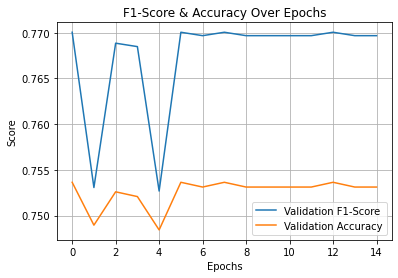

In [48]:
# Tracking F1-Scores and accuracy scores

from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Custom callback to track F1-score and Accuracy
class F1AccuracyTracker(Callback):
    def __init__(self, validation_data):
        self.X_val, self.y_val = validation_data
        self.f1_scores = []
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_val)
        y_pred = (y_pred_probs > 0.5).astype(int)

        f1 = f1_score(self.y_val, y_pred)
        acc = accuracy_score(self.y_val, y_pred)

        self.f1_scores.append(f1)
        self.accuracies.append(acc)

        print(f"Epoch {epoch+1}: val_f1 = {f1:.4f}, val_acc = {acc:.4f}")

# Initialize the combined tracker
f1_acc_callback = F1AccuracyTracker(validation_data=(X_test_scaled, y_test))

# Rebuild the model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Add EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stop, f1_acc_callback],
    verbose=1
)

# Plot F1 and Accuracy over epochs
plt.plot(f1_acc_callback.f1_scores, label='Validation F1-Score')
plt.plot(f1_acc_callback.accuracies, label='Validation Accuracy')
plt.title("F1-Score & Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


60/60 [==============================] - 0s 447us/step
 ROC AUC Score: 0.8383


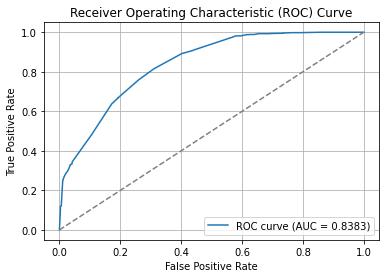

In [49]:
# Adding ROC and AUC scores to assess class separation quality.

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# 1. Predict probabilities
y_pred_probs = model.predict(X_test_scaled)

# 2. Compute ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f" ROC AUC Score: {roc_auc:.4f}")

# 3. Compute ROC Curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc_line = auc(fpr, tpr)

# 4. Plot the ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_line:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [50]:
# Saving the model and scaler for deployment

import joblib

# Save model
model.save("mlp_financial_inclusion_model.keras")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save scaler
joblib.dump(top_features, "selected_features.pkl")

['selected_features.pkl']